In [38]:
# https://machinelearningmastery.com/deep-learning-bag-of-words-model-sentiment-analysis/
'''
vectorising using sklearn
using pre-trained glove embedding
using initialized tf-idf vocab --> weights of glove matrix
CNN architecture
'''

import os
from tqdm import tqdm
import pandas as pd 
import numpy as np
 
from keras.models import Sequential
from keras.layers import Dense, GRU, Embedding, LSTM, Dropout, CuDNNGRU
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from sklearn.feature_extraction.text import TfidfVectorizer #CountVectorizer()
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

import pickle
import h5py

from time import time

from tensorflow.keras.callbacks import TensorBoard



PROJ_NAME= "1.1 Vector LOCAL Glove 50dims TF-iDF"
tensorboard = TensorBoard(log_dir=f'logs/,{PROJ_NAME}/')

In [39]:
INPUT_TEXT_LENGTH = 695 # from previous notebook

# Reading Pickle

In [40]:
df_preprocessed = pd.read_pickle("./pickles/1_processed_pos_tag.pkl")

In [41]:
df_preprocessed.columns

Index(['review', 'word_count', 'sentiment'], dtype='object')

# Vectorising tf-idf SKLEARN

In [42]:
#analyzer : string, {‘word’, ‘char’, ‘char_wb’} 
#   min_df=3, max_df=0.9
'''
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

#  l2 norm ==>      so that the length of a document does not bias its representation
# sublinear_tf ==>  we will use the log of the frequency, as word frequencies follow an exponential distribution 
# Bigrams ==>       word  different meaning than each of their components separately (e.g “box office” vs “box” and “office”).
'''
tfidf_vectorizer  =  TfidfVectorizer(max_features=10000,
                             min_df=7,  # ignore terms that appear in less than 5 documents".
                             max_df=0.7,#  ignore terms that appear in more than 50% of documents". 
                             analyzer='word' 
                            )


In [43]:
%%time
tfidf_BOW  = tfidf_vectorizer.fit_transform(df_preprocessed['review'])

Wall time: 1.5 s


# Vocab of tf-idf terms

In [44]:
#arr=[]
tfidf_vocab = tfidf_vectorizer.vocabulary_
print(tfidf_vocab)

{'plot': 5968, 'two': 8243, 'teen': 7900, 'couple': 1806, 'go': 3428, 'church': 1408, 'party': 5760, 'drink': 2426, 'drive': 2429, 'accident': 158, 'guy': 3582, 'die': 2210, 'girlfriend': 3397, 'continue': 1723, 'see': 6966, 'life': 4641, 'nightmare': 5407, 'deal': 2014, 'watch': 8642, 'sorta': 7378, 'find': 3046, 'critique': 1883, 'mind': 5096, 'fuck': 3264, 'generation': 3350, 'touch': 8107, 'cool': 1763, 'idea': 3931, 'present': 6112, 'bad': 688, 'package': 5699, 'review': 6648, 'even': 2749, 'hard': 3637, 'write': 8835, 'since': 7194, 'generally': 3346, 'applaud': 483, 'attempt': 611, 'break': 1025, 'mold': 5174, 'mess': 5050, 'head': 3675, 'lose': 4748, 'highway': 3759, 'good': 3450, 'way': 8651, 'type': 8246, 'folks': 3132, 'correctly': 1782, 'seem': 6970, 'take': 7846, 'pretty': 6127, 'neat': 5340, 'concept': 1640, 'execute': 2806, 'terribly': 7939, 'problem': 6158, 'well': 8684, 'main': 4847, 'simply': 7188, 'start': 7524, 'normal': 5441, 'fantasy': 2930, 'world': 8808, 'audien

# Chi-Squared for Feature Selection
* its significance: 

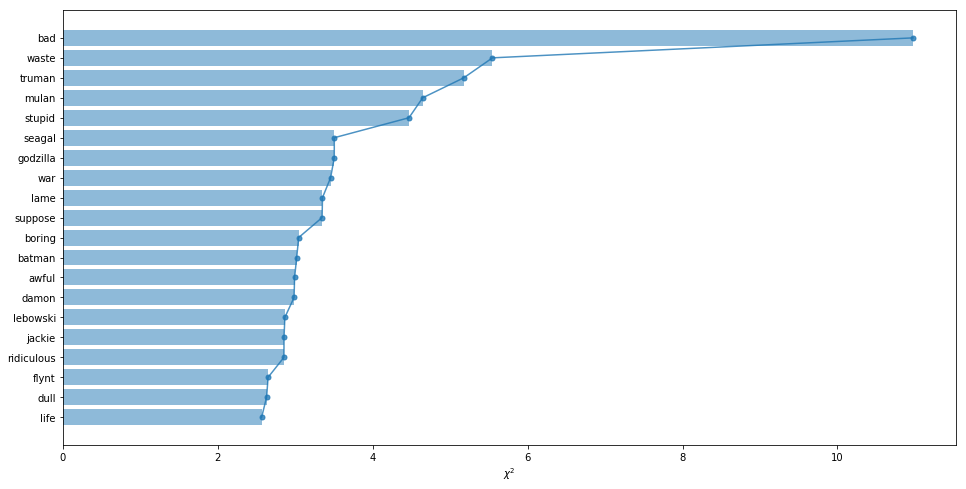

In [45]:
from sklearn.feature_selection import chi2

chi2score = chi2(tfidf_BOW, df_preprocessed['sentiment'])[0]
plt.figure(figsize=(16,8))
scores = list(zip(tfidf_vectorizer.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();


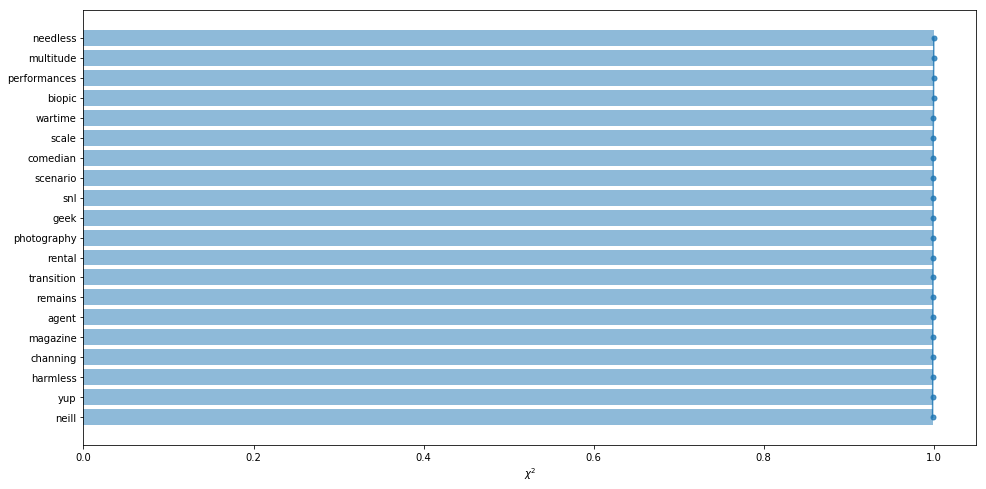

In [46]:
from sklearn.feature_selection import chi2

chi2score = chi2(tfidf_BOW, df_preprocessed['sentiment'])[1]
plt.figure(figsize=(16,8))
scores = list(zip(tfidf_vectorizer.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();

# Setting up vocab size

In [47]:
VOCAB_SIZE = len(tfidf_vocab)
VOCAB_SIZE = VOCAB_SIZE + 1
print(VOCAB_SIZE)

8892


# Mapping  tokens to tf-idf int sequences

In [48]:
from nltk.tokenize import sent_tokenize, word_tokenize
#MU LOCAL FUNCTION
#converting word token to corresponding int value
def df_to_seq(review):
    tokens = word_tokenize(review) 
    lst = [ tfidf_vocab.get(token,) for token in tokens]
    return lst 

In [49]:
'''
inv_map = {v: k for k, v in sorted(tfidf_vocab.items()) }
inv_map
'''
seq = df_preprocessed['review'].apply(lambda x : df_to_seq(x))

In [50]:
seq[1]

[3634,
 749,
 None,
 6307,
 None,
 6648,
 1967,
 None,
 1099,
 None,
 3467,
 3675,
 7524,
 None,
 7514,
 4275,
 4579,
 1936,
 445,
 702,
 1076,
 8745,
 None,
 7591,
 6477,
 1867,
 None,
 1564,
 190,
 None,
 6801,
 7886,
 7102,
 None,
 4429,
 6064,
 679,
 4692,
 4469,
 6064,
 8778,
 3428,
 3462,
 1055,
 194,
 7011,
 8549,
 7566,
 2982,
 2617,
 None,
 None,
 3428,
 3081,
 7676,
 None,
 4469,
 1867,
 6409,
 5075,
 5473,
 None,
 4469,
 5612,
 7846,
 7102,
 859,
 5915,
 3083,
 7992,
 3775,
 None,
 1810,
 None,
 4469,
 2356,
 7792,
 7649,
 524,
 None,
 8022,
 None,
 None,
 3749,
 4616,
 None,
 1336,
 5822,
 524,
 6723,
 None,
 193,
 651,
 2749,
 None,
 1936,
 None,
 4656,
 None,
 4429,
 8803,
 3606,
 3586,
 7792,
 8639,
 702,
 8684,
 None,
 191,
 None,
 702,
 1810,
 6399,
 7514,
 7504,
 None,
 None,
 6723,
 2146,
 None,
 1296,
 5521,
 3450,
 3462,
 7125,
 None,
 5899,
 7351,
 None,
 1007,
 6723,
 940,
 5751,
 6409,
 8225,
 None,
 None,
 5622,
 None,
 6127,
 5246,
 None,
 7102,
 None]

# Removing int values not in tfidf vocab i.e values above 8892

In [51]:
tfidf_sequence = []
for sublist in seq:
    cleaned = [elem for elem in sublist if elem is not None]
    if len(cleaned):  # anything left?
        tfidf_sequence.append(cleaned)

# Importing pre trained Glove
* https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html 

In [52]:
Glove_Embedding = {}#dict()
                                                                #100d
f = open('D:/dataset/Embedding/Glove/glove.6B.50d.txt', encoding="utf8")

for line in f:
	values = line.split() # split by lines
	word = values[0]# get 1st word in the line i.e the "word" itself
	coefs = np.asarray(values[1:], dtype='float32') # the preceding vector is the vector itself
	Glove_Embedding[word] = coefs# its a dict of word(key) and vector(value)
f.close()

print('Loaded %s word vectors.' % len(Glove_Embedding))

Loaded 400000 word vectors.


# Pre trained Glove, used as initilzation for our task
  - we create 2D array of size (VOCAB_SIZE * 50) 

In [53]:
#so we have to create 2d array
# 50 since we have loaded 50 embd layer Glove matrix

embedding_matrix = np.zeros((VOCAB_SIZE,50))
##words_not_found = []   # words not found in Glove emb. w.r.t our data corpous
import collections
words_not_found = collections.defaultdict(list)

for word, i in tfidf_vocab.items():
    
    glove_vector_reprsentation = Glove_Embedding.get(word,"NULL")
    if glove_vector_reprsentation != 'NULL':
        embedding_matrix[i] = glove_vector_reprsentation
    else:
        ##words_not_found.append(word)
        words_not_found[word].append(i)      #words not found in Glove embedding; ALSO STORE INDEX LOCATION

C:\Users\DBCE\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sys.path[0] == '':


In [54]:
print(Glove_Embedding.get('joblo',"NULL"))
print(embedding_matrix[5329]) # its 1D array

NULL
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [55]:
words_not_found  #words not found in Glove embedding; CAN USE WORDCLOUD

defaultdict(list,
            {'joblo': [4327],
             'convolute': [1759],
             'excruciate': [2801],
             'cheezy': [1352],
             '_the': [117],
             'appal': [476],
             'overbear': [5654],
             'impend': [3983],
             'engross': [2643],
             'derange': [2132],
             'stylize': [7662],
             'enthral': [2672],
             '_is_': [116],
             'underdevelop': [8295],
             'nauseate': [5329],
             'forebode': [3153],
             'exhilarate': [2813]})

In [56]:
embedding_matrix.shape # Embedding layer matrix

(8892, 50)

# Glove similarity 50D to OOV lookup ====> modelGlove

In [57]:
'''
from gensim.scripts.glove2word2vec import glove2word2vec

word2vec_output_file = 'D:/dataset/Embedding/Glove/glove.6B.50d.txt.word2vec'# new outputed file

from gensim.models import KeyedVectors
# load the Stanford GloVe model
modelGlove = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
'''

"\nfrom gensim.scripts.glove2word2vec import glove2word2vec\n\nword2vec_output_file = 'D:/dataset/Embedding/Glove/glove.6B.50d.txt.word2vec'# new outputed file\n\nfrom gensim.models import KeyedVectors\n# load the Stanford GloVe model\nmodelGlove = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)\n"

# Handling OOV words by finding most_similar word

In [58]:
'''
1. for FASTEXT and W@V  we can use :
# model.most_similar_cosmul('run') or most_similar('run')        // function call

2. for Glove:
https://stackoverflow.com/questions/47365480/get-most-similar-words-using-glove
'''
similar_to_OOV = []

for word in words_not_found:    
    try:                
        thr = modelGlove.wv.most_similar_cosmul(word) # model.wv.most_similar(word)
        print(thr[0][1], "  ", thr[0][0])        
        
        if thr[0][1] > 0.48:     # if word found and is abv threashold then append thr[0][0] i.e name       
            similar_to_OOV.append(thr[0][0])            
        else:                    # if found with below threashold           
            similar_to_OOV.append('<unk>')      
           
            
    except:                      # if no mkatch found
        similar_to_OOV.append('<UNK>')


#model.wv.most_similar_cosmul(engross)

# manually check new substituted word if embedding are good enough

In [59]:
# Maintainig 2 list to check 

print(words_not_found)
print(similar_to_OOV)

#modelGlove.wv.most_similar_cosmul('engross')


# OTHERWISE  ALTER word_not_found DICTIONARY HERE ITSELF and assign it to similar_words


defaultdict(<class 'list'>, {'joblo': [4327], 'convolute': [1759], 'excruciate': [2801], 'cheezy': [1352], '_the': [117], 'appal': [476], 'overbear': [5654], 'impend': [3983], 'engross': [2643], 'derange': [2132], 'stylize': [7662], 'enthral': [2672], '_is_': [116], 'underdevelop': [8295], 'nauseate': [5329], 'forebode': [3153], 'exhilarate': [2813]})
['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']


# Fill emb_matrix again with similar or random values

In [60]:
'''#creating vectors out of it n handling
for new_similar_word in similar_to_OOV:
    if prev_original_word in words_not_found.keys():
        
        loc = words_not_found[prev_original_word]  # where the location had all 0 vectors
        glove_vector_reprsentation = Glove_Embedding.get(new_similar_word,"NULL") # retrive to its most similar
        
        if glove_vector_reprsentation != 'NULL':
            embedding_matrix[loc] = glove_vector_reprsentation # save the new_similar_word vector in prev_original_word array location
            
    else:
        
        
        # here all prev those are below threashold or <UNK>
        # could be randomly initialized and added to main matrix
        #loc = words_not_found[prev_original_word]
        #define EMBEDIING_SIZE= 50 as global
        #embedding_matrix[loc] =  np.random.rand(50)  OR  embedding_matrix[loc] =  np.random.uniform(-1,1,50)
        # whicheevr suits well
'''
        
'''
Instead of assigning all the Out of Vocabulary tokens to a common UNK vector (zeros), 
it is better to assign them a unique random vector. At-least this way when you find the similarity between them
with any other word, each of them will be unique and the model can learn something out of it. In the UNK case,
they will all be same and so all the UNK words will be treated as having the same context.

I tried this approach and got a 3% accuracy improvement on the Quora Duplicate question pair detection dataset using an LSTM model.
      
'''     

'\nInstead of assigning all the Out of Vocabulary tokens to a common UNK vector (zeros), \nit is better to assign them a unique random vector. At-least this way when you find the similarity between them\nwith any other word, each of them will be unique and the model can learn something out of it. In the UNK case,\nthey will all be same and so all the UNK words will be treated as having the same context.\n\nI tried this approach and got a 3% accuracy improvement on the Quora Duplicate question pair detection dataset using an LSTM model.\n      \n'

# Padding and Truncating Data
* To feed it to N.N, inputs to have the same length
  - Either we ensure that all sequences in the entire data-set have the same length
  - Or Entier batch should be of same length
* Going about choosing ampunt to pad
  - going with longest seq, would be just waste of memory for texr whose length is small
  - going with smalles seq , would be just ignoring other imp values
  - so we go optimal

In [61]:
#imdb_data_pad = sequence.pad_sequences(tfidf_sequence, maxlen=MAX_TOKENS,padding='pre', truncating='pre') 

imdb_data_pad = sequence.pad_sequences(tfidf_sequence, maxlen= INPUT_TEXT_LENGTH,padding='pre', truncating='pre') 

In [62]:
print(imdb_data_pad[4])
print(len(imdb_data_pad[5]))

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

# Split Data

In [76]:
X= imdb_data_pad #PADDED VERSION OF DATA
y= df_preprocessed['sentiment'] # LABELS OF DATA

X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.33, random_state=42)

In [64]:
'''
def export_test_train_data_to_h5(filename, X_train, X_test, y_train, y_test):
    #filename has to be xyzw.h5 with extension
    h5f = h5py.File(filename, 'w')
    h5f.create_dataset('X_train', data=X_train)           #np.ndarry
    h5f.create_dataset('y_train', data=np.array(y_train)) #pd df
    h5f.create_dataset('X_test', data=X_test)
    h5f.create_dataset('y_test', data=np.array(y_test))
    h5f.create_dataset('embedding_matrix', data=np.array(embedding_matrix))
    # export weights of embedding_matrix incase of  
    h5f.close()
    print("file created")
    
filename = "2_1_tf-idf.h5"    

export_test_train_data_to_h5(filename,X_train, X_test, y_train, y_test)
'''

'\ndef export_test_train_data_to_h5(filename, X_train, X_test, y_train, y_test):\n    #filename has to be xyzw.h5 with extension\n    h5f = h5py.File(filename, \'w\')\n    h5f.create_dataset(\'X_train\', data=X_train)           #np.ndarry\n    h5f.create_dataset(\'y_train\', data=np.array(y_train)) #pd df\n    h5f.create_dataset(\'X_test\', data=X_test)\n    h5f.create_dataset(\'y_test\', data=np.array(y_test))\n    h5f.create_dataset(\'embedding_matrix\', data=np.array(embedding_matrix))\n    # export weights of embedding_matrix incase of  \n    h5f.close()\n    print("file created")\n    \nfilename = "2_1_tf-idf.h5"    \n\nexport_test_train_data_to_h5(filename,X_train, X_test, y_train, y_test)\n'

# TRAIN MODEL

In [65]:
%%time
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

'''

# create the model
model = Sequential()
embedding_layer = Embedding(VOCAB_SIZE, 50, weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

'''

Wall time: 0 ns


In [73]:
%%time
model = Sequential()
                   #vocab_size
#model.add(Embedding(VOCAB_SIZE, 50, input_length=INPUT_TEXT_LENGTH))
embedding_layer = Embedding(VOCAB_SIZE, 50, weights=[embedding_matrix], input_length=INPUT_TEXT_LENGTH, trainable=False)
model.add(embedding_layer)
'''
model.add(Dropout(0.2))
'''
#increase this parameter
model.add(GRU(units=50))#return_sequences=True
#model.add(CuDNNGRU(units=50))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 695, 50)           444600    
_________________________________________________________________
gru_4 (GRU)                  (None, 50)                15150     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 459,801
Trainable params: 15,201
Non-trainable params: 444,600
_________________________________________________________________
None
Wall time: 1.23 s


In [74]:
# print out model image
from keras.utils import plot_model
import os
#install graph viz locally 1st
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'# install 
plot_model(model, to_file=f'model_images/{PROJ_NAME}.png')

In [77]:
 
# use validation_split=0.08 only incase data is not been splitte earlier

# TENSORBOARD
'''
# tensorboard --logdir logs/keras-lstm-2.1
# http://localhost:6006/
'''

'''HERE PROBLEM IS TF-IDF HAS generatted vocab of 8892
   Rest of vocab words are none.. that we remove in above function
   So randomly some terms are removed, which coz imp words might be lost( word ordering)
'''

#TO DO
# TRY TO EXPORT TRAIN / TEST FILE 
#INCLUDE TENSORBOARD GRAPH


history = model.fit(X_train, y_train, epochs=3, validation_data=(X_val,y_val), batch_size=64, verbose=2, callback=[tensorboard])
    

TypeError: Unrecognized keyword arguments: {'callback': [<tensorflow.python.keras.callbacks.TensorBoard object at 0x0000029AFC54FB00>]}

In [32]:
# plot train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

NameError: name 'history' is not defined

In [ ]:
# Final evaluation of the model
#scores = model.evaluate(X_test, y_test, verbose=0)
#print("Accuracy: %.2f%%" % (scores[1]*100))